<h1>Lecture 5, September 29, 2025 </h1>

<h1> Forecasting using ARIMA and ADL models </h1>

Marta Boczon

Department of Economics

Copnehagen Business School

mbo.eco@cbs.dk

In [1]:
#install.packages("quantmod")
#install.packages("fredr")
#install.packages("ggfortify")
#install.packages('urca')
#install.packages("tseries")
#install.packages("forecast")
#install.packages("dynlm")
#install.packages("stargazer")
#install.packages("pracma")
#install.packages("dLagM")
#install.packages("gets")
#install.packages("car")
#install.packages("lmtest")
#install.packages("astsa")
#install.packages("zoo")
#install.packages("conflicted")
#library(conflicted)
#conflict_prefer("lag", "stats")
options(warn=-1)

**Introduction**

Today we will focus on finding ADL models and forecasting using **ARIMA** and **ADL** models.  
For this exercise, we will work with two Canadian macroeconomic series:

1. **Canadian GDP** – the same quarterly series we introduced in Lecture 3.  
2. **Weekly hours worked in the Canadian manufacturing sector** – the same quarterly series we introduced in Lecture 4.



**Data Transformations**

We begin by importing the data and transforming it to achieve **stationarity**, which is a prerequisite for applying ARIMA and/or ADL models.

- For **GDP**, we take the **first difference of the logarithm**.  
  - This transformation allows us to interpret the series in terms of *quarterly growth rates*, while also stabilizing the variance and removing the stochastic trend.  

- For **hours worked**, we take the **first difference of the level series**.  
  - This transformation removes the unit root identified in the original series.   

With these transformations, we now have two stationary series suitable for ARIMA and ADL modeling.  


In [2]:
# Import the dataset from a CSV file downloaded from FRED
gdp =read.csv("NGDPRSAXDCCAQ.csv")
# Convert the second column of the dataset into a time series object
tsgdp = ts(gdp[, 2], frequency = 4, start = c(1961, 1))
# Transform the series into (approximate) percentage changes
dgdp = diff(log(tsgdp))

In [3]:
# Import the dataset from a CSV file downloaded from FRED
hours = read.csv("HOHWMN02CAM065N.csv")
# Convert the second column of the dataset into a time series object
tshours = ts(hours[, 2], frequency = 4, start = c(1960, 1))
# Transform the series into a change from the previous period
dhours = diff(tshours)

# Exhaustive ADL subset search based on parameter significance

In [4]:
##############################################
## Exhaustive ADL Subset Search based on parameter significance
## Goal: start from a general ADL(4,4) and iteratively drop the
##       least significant regressor until all remaining have
##       |t| >= 1.96 (≈ 5% two-sided level), or none remain.
##############################################

data = ts.intersect(dgdp, dhours)  # Align (intersect) the two input ts objects to a common sample

library(gets)                             

## ---- 1) Create lagged variables ------------------------------------------
## Assume 'data' is a bivariate ts object: 
##   - column 1: y (e.g., GDP growth)
##   - column 2: x (e.g., ΔHours worked)
## We build up to 4 lags for each series. Using negative 'k' in lag(z, -k)
## shifts the series BACK by k steps so that, e.g., lag(y,-1) corresponds to y_{t-1}.

y0 = data[, 1]                # y_t (dependent variable at time t)

y1 = lag(data[, 1], -1)       # y_{t-1}  (first own lag of y)
y2 = lag(data[, 1], -2)       # y_{t-2}
y3 = lag(data[, 1], -3)       # y_{t-3}
y4 = lag(data[, 1], -4)       # y_{t-4}

x1 = lag(data[, 2], -1)       # x_{t-1}  (first lag of x)
x2 = lag(data[, 2], -2)       # x_{t-2}
x3 = lag(data[, 2], -3)       # x_{t-3}
x4 = lag(data[, 2], -4)       # x_{t-4}

tempdata = ts.intersect(      # Align y_t and all lags so rows line up (drop initial NA rows from lags)
  y0,
  y1, y2, y3, y4,
  x1, x2, x3, x4
)

# Separate dependent and independent variables after alignment
depvar = tempdata[, 1]                        # y_t
indvar = tempdata[, 2:ncol(tempdata)]         # [y_{t-1..4}, x_{t-1..4}]

# Name columns explicitly for readability/tracking during elimination
colnames(indvar) = c("y1","y2","y3","y4","x1","x2","x3","x4")

# Initialize min |t| to trigger entry into the loop
tmin = 0                                      

# Main backward-elimination loop based on individual t-statistics:
# Continue while the smallest absolute t-stat among non-constant coefficients is < 1.96.
while (tmin < 1.96) {
 
         # Estimate ARX with current regressor set 'indvar' and a constant (mc=TRUE).
         # try(..., silent=TRUE) avoids stopping on errors (e.g., singular design), and
         # suppressWarnings(...) silences routine warnings during re-estimation.
         model = try(suppressWarnings(arx(depvar, mxreg = indvar, mc = TRUE)), silent = TRUE)

         print(model)                # Print iteration’s model object (useful to monitor retained vars)

         b  = coef(model)             # Named vector of estimated coefficients (incl. constant 'mconst')
         V  = vcov(model)             # Variance–covariance matrix of estimates
         se = sqrt(diag(V))           # Standard errors from diagonal of V
      
         tstat = b / se              # Compute coefficient-wise t-statistics

         # Drop the constant's t-stat from the elimination rule:
         # We only compare *slope* coefficients (lags) to the threshold, not 'mconst'.
         tstat = tstat[setdiff(names(tstat), "mconst")]

         if (length(tstat) == 0) break         # If no slope coefficients are left, stop the loop

        tstat = abs(tstat)                     # Work with absolute t-values for two-sided testing
        tmin = min(tstat)                      # Record the smallest |t| among current regressors

        # Identify the variable with the minimum |t| and prepare a new regressor set that excludes it.
        # setdiff(colnames(indvar), names(which.min(tstat))) returns all columns except the one with min |t|.
        k = setdiff(colnames(indvar), names(which.min(tstat))) 

        # If dropping that variable leaves no columns, set indvar to NULL 
        # (intercept-only ARX on next iteration/exit).
        if (length(k) == 0) indvar = NULL 

        # Otherwise, keep all remaining columns 
        # (drop = FALSE preserves matrix structure when selecting a single column).
        if (length(k) != 0)  indvar = indvar[, k, drop = FALSE]


        # Loop continues until every remaining slope has |t| >= 1.96 (or no slopes remain).
    
}
print(model)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: parallel




Date: Mon Oct  6 16:11:55 2025 
Dependent var.: depvar 
Method: Ordinary Least Squares (OLS) 
Variance-Covariance: Ordinary 
No. of observations (mean eq.): 246 
Sample: 1962(2) to 2023(3) 

Mean equation:

              coef   std.error  t-stat   p-value    
mconst  0.00663890  0.00131206  5.0599 8.411e-07 ***
y1     -0.01557032  0.06819366 -0.2283   0.81959    
y2      0.03205575  0.06793092  0.4719   0.63744    
y3      0.01339174  0.06757077  0.1982   0.84307    
y4      0.06839600  0.06566642  1.0416   0.29867    
x1      0.00552215  0.00254866  2.1667   0.03126 *  
x2     -0.00225605  0.00270668 -0.8335   0.40540    
x3      0.00263759  0.00267562  0.9858   0.32524    
x4      0.00073847  0.00255386  0.2892   0.77271    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Diagnostics and fit:

                      Chi-sq df   p-value    
Ljung-Box AR(1)   1.2137e-05  1    0.9972    
Ljung-Box ARCH(1) 4.5282e+01  1 1.706e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 

In [5]:
library(gets)
#https://search.r-project.org/CRAN/refmans/sysid/html/arx.html
#https://cran.r-project.org/web/packages/gets/gets.pdf

##GETS-modelling of mean specification:

#getsm(object, t.pval=0.05, wald.pval=t.pval, vcov.type=NULL,
#do.pet=TRUE, ar.LjungB=list(lag=NULL, pval=0.025),
#arch.LjungB=list(lag=NULL, pval=0.025), normality.JarqueB=NULL,
#user.diagnostics=NULL, info.method=c("sc","aic","aicc", "hq"),
#gof.function=NULL, gof.method=NULL, keep=NULL, include.gum=FALSE,
#include.1cut=TRUE, include.empty=FALSE, max.paths=NULL, tol=1e-07,
#turbo=FALSE, print.searchinfo=TRUE, plot=NULL, alarm=FALSE)

# y-series: current value and its lags -------------------------------------------------

y0 = data[,1]                 # y_t : dependent variable at time t (first column of 'data')

y1 = lag(data[,1], -1)        # y_{t-1} : first lag of y 
y2 = lag(data[,1], -2)        # y_{t-2} : second lag of y
y3 = lag(data[,1], -3)        # y_{t-3} : third lag of y
y4 = lag(data[,1], -4)        # y_{t-4} : fourth lag of y

# x-series: lags -----------------------------------------------------------------------

x1 = lag(data[,2], -1)        # x_{t-1} : first lag of x (second column of 'data')
x2 = lag(data[,2], -2)        # x_{t-2} : second lag of x
x3 = lag(data[,2], -3)        # x_{t-3} : third lag of x
x4 = lag(data[,2], -4)        # x_{t-4} : fourth lag of x

# Align all series on a common time index (drop rows with any NA from lagging) --------

tempdata = ts.intersect(
  y0,                         # y_t
  y1, y2, y3, y4,             # y lags: y_{t-1..4}
  x1, x2, x3, x4              # x lags: x_{t-1..4}
)

# Split into dependent and regressor blocks -------------------------------------------

depvar = tempdata[, 1]                    # dependent variable y_t after alignment
indvar = tempdata[, 2:ncol(tempdata)]     # matrix of regressors: (y_{t-1..4}, x_{t-1..4})

# Estimate general ADL with a constant, then run gets reduction -----------------------

model.temp = arx(depvar, mxreg = indvar, mc=TRUE)  # ARX/ADL: depvar ~ indvar + constant

getfit = getsm(
  model.temp,
  arch.Ljung = NULL,        # (diagnostics option) here set to NULL → skip ARCH Ljung-Box check
  print.searchinfo = FALSE, # suppress verbose search output
  t.pval = 0.05             # 5% threshold for t-tests during general-to-specific reduction
)

getfit                      # final selected (simplified) model object


Date: Mon Oct  6 16:11:55 2025 
Dependent var.: depvar 
Method: Ordinary Least Squares (OLS) 
Variance-Covariance: Ordinary 
No. of observations (mean eq.): 246 
Sample: 1962(2) to 2023(3) 

SPECIFIC mean equation:

            coef std.error t-stat p-value    
mconst 0.0073650 0.0007963 9.2490 < 2e-16 ***
x1     0.0052970 0.0021778 2.4323 0.01572 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Diagnostics and fit:

                     Chi-sq df   p-value    
Ljung-Box AR(1)    0.043719  1    0.8344    
Ljung-Box ARCH(1) 49.375064  1 2.114e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
                          
SE of regression   0.01248
R-squared          0.02367
Log-lik.(n=246)  730.25453

The manual loop performs a backward-elimination search starting from a general ADL(4,4) model. In each iteration, it estimates the current model with a constant, computes t-statistics for all non-constant coefficients, and identifies the regressor with the smallest absolute t-statistic. That weakest term is dropped, the model is re-estimated on the reduced set, and the process repeats. The loop stops when either no regressors remain or all surviving slope coefficients satisfy ∣𝑡|≥1.96, which corresponds to an approximate 5% two-sided significance threshold under large-sample normality. This greedy, nested-model approach is transparent and easy to follow, though it does not guarantee a globally optimal subset in terms of information criteria.

The getsm() routine from the GETS framework automates the same reduction while allowing for optional diagnostic checks.

<img src="COLOURBOX36254980.jpg" width="200">

# Exercise:

Use iterative elimination of insignificant parameters to find the best model for Canadian GDP as a function of weekly hours worked in the manufacturing sector in Canada and personal consumption expenditures in the US. This approach begins from a general specification and gradually removes regressors that do not meet a chosen significance threshold, leaving a parsimonious model where all remaining coefficients are individually meaningful.

To transform the monthly data on PCE into quarterly frequency, as we practiced together in Lecture 3, please run the code below. This step ensures that the frequency of all variables is aligned before estimating the model, which is crucial for meaningful inference.

In [6]:
library(zoo) 

# Import the dataset from a CSV file downloaded from FRED --------------------
temp = read.csv("PCE.csv")               # reads the CSV into a data.frame 'temp'

# Parse monthly dates --------------------------------------------------------
# Convert the character/date column 'observation_date' to a monthly index.
# as.yearmon stores dates as Year-Month (e.g., 2020-01) without a specific day.
temp$Date = as.yearmon(temp$observation_date)

# Aggregate monthly to quarterly --------------------------------------------
# Collapse the monthly series 'PCE' to calendar quarters using the mean of the
# three months in each quarter. Replace FUN as needed (sum, last, etc.).
pce = aggregate(PCE ~ as.yearqtr(Date), data = temp, FUN = mean)

head(pce)                     # quick peek at the first few quarterly observations
tail(pce)                     # quick peek at the most recent quarterly observations

# Convert the second column of the quarterly data to a ts object -------------
# Create a quarterly 'ts' starting in 1959 Q1. 'frequency = 4' indicates quarterly data.
# pce[, 2] is the numeric series (PCE levels) and the first column is the quarter index.
tspce = ts(pce[, 2], frequency = 4, start = c(1959, 1))

,as.yearqtr(Date),PCE
,<yearqtr>,<dbl>
1,1959 Q1,309.4667
2,1959 Q2,315.5000
3,1959 Q3,320.7333
4,1959 Q4,322.8667
5,1960 Q1,326.3667
6,1960 Q2,332.2000


,as.yearqtr(Date),PCE
,<yearqtr>,<dbl>
262,2024 Q2,19682.70
263,2024 Q3,19938.47
264,2024 Q4,20255.47
265,2025 Q1,20461.60
266,2025 Q2,20643.90
267,2025 Q3,20802.00


# Solution:

In [7]:
# Calculate the number of observations in the time series object
nd = length(tspce)

# Print a message along with the number of observations
cat("There are", nd, "observations in our data set.")

There are 267 observations in our data set.

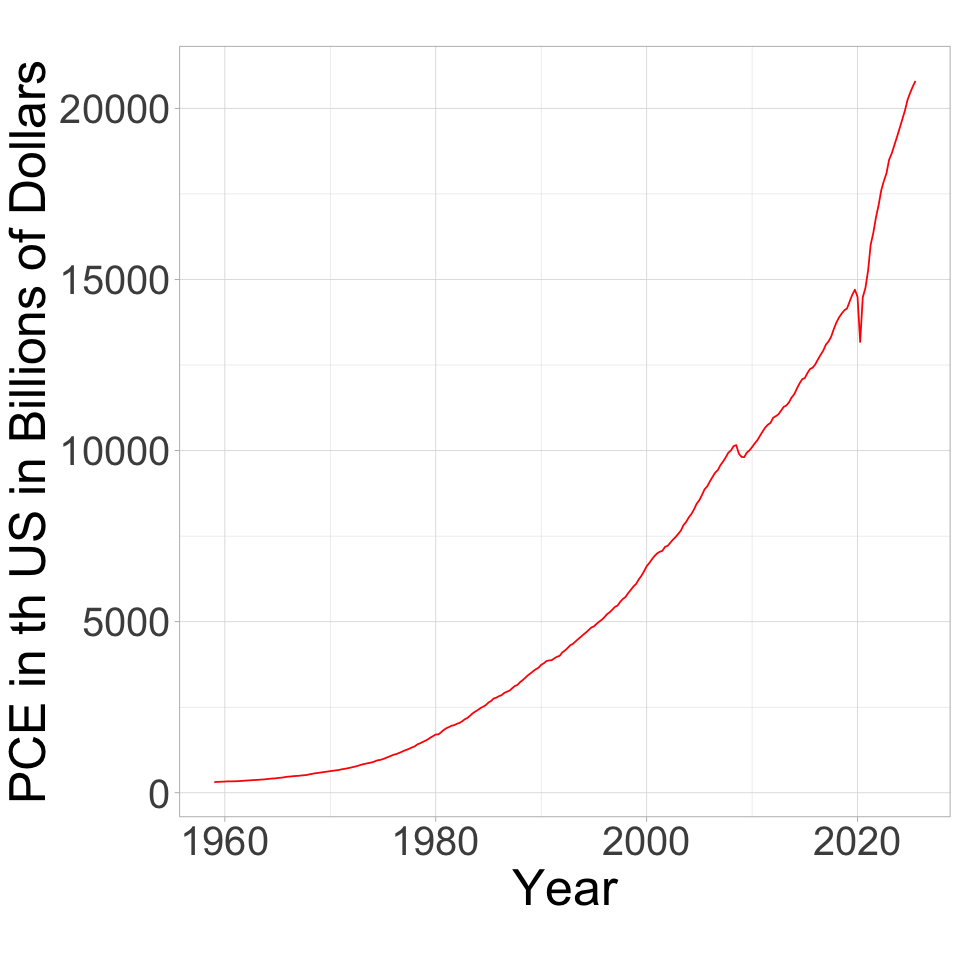

In [8]:
# Load required libraries
library(ggplot2)   # for plotting
library(ggfortify) # for autoplot of time series objects

# Set default figure size (width = 8, height = 8)
options(repr.plot.width = 8, repr.plot.height = 8)

# Create an initial time series plot of tspce in red
fig = autoplot(tspce, colour = 'red')

# Customize the plot
fig = fig +
  theme(aspect.ratio = 1) +                      # make plot square-shaped
  theme_light() +                                # use a light theme
  theme(aspect.ratio = 1) +                      # reinforce square aspect ratio
  theme(plot.margin = ggplot2::margin(0.2, 0.2, 0.2, 0.2, "cm")) + # adjust margins
  theme(text = element_text(size = 30)) +        # set large font size for readability
  labs(x = "Year") +                             # label x-axis
  labs(y = "PCE in th US in Billions of Dollars")# label y-axis

# Display the plot
fig


In [9]:
library(urca)
summary(ur.df(tspce, type='trend', lags=8, selectlags="AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1527.58   -12.04    -0.07    16.55  1023.51 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept) 12.868353  25.266869   0.509   0.6110  
z.lag.1      0.013244   0.005267   2.514   0.0125 *
tt          -0.058207   0.375801  -0.155   0.8770  
z.diff.lag  -0.080146   0.063596  -1.260   0.2087  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 136.6 on 254 degrees of freedom
Multiple R-squared:   0.18,	Adjusted R-squared:  0.1703 
F-statistic: 18.58 on 3 and 254 DF,  p-value: 6.27e-11


Value of test-statistic is: 2.5144 34.6555 25.5984 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -3.98 -3.42 -3.13
phi2  6.15  

**Interpretation**:

We compare the reported test statistics (2.5144, 34.6555, 25.5984)  to the critical values table.

Since the test statistic exceeds the relevant critical values, we reject the null hypothesis that the deterministic trend and constant are both zero.

This means that even after including a deterministic trend and constant, the series still behaves as if it has a unit root (i.e., it is non-stationary).

Because the data show exponential growth (a trending level effect), we need to first take the logarithm of the series. This stabilizes the trend by converting exponential growth into a linear trend. After logging, we then difference the series (log-differences correspond to growth rates) and retest for a unit root on the transformed series.

In [10]:
# Transform the PCE time series into growth rates ----------------------------
# 1. log(tspce): take natural logarithm of the level series (stabilizes exponential growth)
# 2. diff(...): compute first differences of the logged series (log-differences ≈ growth rates)
dpce = diff(log(tspce))

In [11]:
library(urca)
summary(ur.df(dpce, type='trend', lags=8, selectlags="AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.106581 -0.003592 -0.000344  0.003573  0.086624 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.679e-02  2.693e-03   6.236 1.88e-09 ***
z.lag.1     -7.276e-01  9.985e-02  -7.287 4.07e-12 ***
tt          -3.752e-05  1.063e-05  -3.531 0.000492 ***
z.diff.lag1 -2.774e-01  8.568e-02  -3.238 0.001365 ** 
z.diff.lag2 -1.410e-01  6.171e-02  -2.284 0.023206 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01131 on 252 degrees of freedom
Multiple R-squared:  0.5113,	Adjusted R-squared:  0.5036 
F-statistic: 65.92 on 4 and 252 DF,  p-value: < 2.2e-16


Value of test-statistic is: -7.2868 17.7311 26.5967 

Critical va

**Interpretation**:

The reported test statistic for the unit root test is –7.2868, which is far below the 1% critical value of –3.98. This means we can clearly reject the null hypothesis of a unit root in the differenced (growth rate) series. In other words, there is no second unit root.

However, the presence of significant deterministic components is still indicated. This suggests that while the growth rate series is stationary in terms of stochastic trends, it still contains a deterministic trend.

Therefore, we need to detrend the growth rates to remove this deterministic trend and obtain a properly stationary series for further modeling.

In [12]:
# Load the pracma package (provides the detrend() function)
library(pracma)

# Remove the linear trend from the series "temp"
# as.numeric(temp) ensures pracma::detrend() works 
# (expects a numeric vector, not a ts object)
# 'linear' specifies linear detrending
temp = detrend(as.numeric(dpce), 'linear')

# Define the start date for the time series
dpce = ts(temp, frequency = 4, start = c(1959, 2))


Attaching package: ‘pracma’


The following object is masked from ‘package:gets’:

    logit




In [13]:
library(gets)
#https://search.r-project.org/CRAN/refmans/sysid/html/arx.html
#https://cran.r-project.org/web/packages/gets/gets.pdf

##GETS-modelling of mean specification:

#getsm(object, t.pval=0.05, wald.pval=t.pval, vcov.type=NULL,
#do.pet=TRUE, ar.LjungB=list(lag=NULL, pval=0.025),
#arch.LjungB=list(lag=NULL, pval=0.025), normality.JarqueB=NULL,
#user.diagnostics=NULL, info.method=c("sc","aic","aicc", "hq"),
#gof.function=NULL, gof.method=NULL, keep=NULL, include.gum=FALSE,
#include.1cut=TRUE, include.empty=FALSE, max.paths=NULL, tol=1e-07,
#turbo=FALSE, print.searchinfo=TRUE, plot=NULL, alarm=FALSE)

# y-series: current value and its lags -------------------------------------------------

data = ts.intersect(dgdp, dhours, dpce)

y0 = data[,1]                 # y_t : dependent variable at time t 
                              # (first column of 'data')

y1 = lag(data[,1], -1)        # y_{t-1} : first lag of y
y2 = lag(data[,1], -2)        # y_{t-2} : second lag of y
y3 = lag(data[,1], -3)        # y_{t-3} : third lag of y
y4 = lag(data[,1], -4)        # y_{t-4} : fourth lag of y

# x-series: lags -----------------------------------------------------------------------

x1 = lag(data[,2], -1)        # x_{t-1} : first lag of x (second column of 'data')
x2 = lag(data[,2], -2)        # x_{t-2} : second lag of x
x3 = lag(data[,2], -3)        # x_{t-3} : third lag of x
x4 = lag(data[,2], -4)        # x_{t-4} : fourth lag of x

# x-series: lags -----------------------------------------------------------------------

z1 = lag(data[,3], -1)        # z_{t-1} : first lag of z (third column of 'data')
z2 = lag(data[,3], -2)        # z_{t-2} : second lag of z
z3 = lag(data[,3], -3)        # z_{t-3} : third lag of z
z4 = lag(data[,3], -4)        # z_{t-4} : fourth lag of z

# Align all series on a common time index (drop rows with any NA from lagging) --------

tempdata = ts.intersect(
  y0,                         # y_t
  y1, y2, y3, y4,             # y lags: y_{t-1..4}
  x1, x2, x3, x4,             # x lags: x_{t-1..4}
  z1, z2, z3, z4              # z lags: z_{t-1..4}
)

# Split into dependent and regressor blocks -------------------------------------------

depvar = tempdata[, 1]                    # dependent variable y_t after alignment
indvar = tempdata[, 2:ncol(tempdata)]     # matrix of regressors: 
                                          # (y_{t-1..4}, x_{t-1..4}, z_{t-1..4})

# Estimate general ADL with a constant, then run gets reduction -----------------------

model.temp = arx(depvar, mxreg = indvar, mc=TRUE)  # ARX/ADL: depvar ~ indvar + constant

getfit = getsm(
  model.temp,
  arch.Ljung = NULL,       # (diagnostics option) here set to NULL → skip ARCH Ljung-Box check
  print.searchinfo = FALSE,# suppress verbose search output
  t.pval = 0.05            # 5% threshold for t-tests during general-to-specific reduction
)

getfit                     # final selected (simplified) model object


Date: Mon Oct  6 16:11:55 2025 
Dependent var.: depvar 
Method: Ordinary Least Squares (OLS) 
Variance-Covariance: Ordinary 
No. of observations (mean eq.): 246 
Sample: 1962(2) to 2023(3) 

SPECIFIC mean equation:

            coef std.error t-stat p-value    
mconst 0.0073650 0.0007963 9.2490 < 2e-16 ***
x1     0.0052970 0.0021778 2.4323 0.01572 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Diagnostics and fit:

                     Chi-sq df   p-value    
Ljung-Box AR(1)    0.043719  1    0.8344    
Ljung-Box ARCH(1) 49.375064  1 2.114e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
                          
SE of regression   0.01248
R-squared          0.02367
Log-lik.(n=246)  730.25453

**Conclusion**

Do US PCE help to model Canadian GDP?

From the GETS output for the specific mean equation, the final model retains only the intercept and one non-PCE regressor (x1), while all lags of US PCE were eliminated by the reduction search because their t-statistics were below the 5% threshold. In other words, once we control for weekly hours (and the constant), the US PCE terms do not add incremental explanatory power for Canadian GDP—so they are not included in the parsimonious specification.

<img src="COLOURBOX36254980.jpg" width="200">

# Forecasting ARIMA models
## AR(1) model

**Note: We will forecast AR(1) and ARIMA(1,0,1) models *for illustration*, so we can match R’s built-in functions with our manual computations. As we saw last week, the best model by BIC was white noise, while the best model by AIC was a subset ARIMA with an AR term at lag 3 and MA terms at lags 3 and 4.**

**R: Forecasting GDP growth rate using AR(1), 1-step ahead**:

$$\color{blue}{y_t = \alpha_0 + \alpha_1 y_{t-1} +ϵ_t}$$



In [14]:
library(stargazer)
# Fit an AR(1) to already-stationary GDP growth (dgdp)
model.a = arima(dgdp, order = c(1, 0, 0))

# Print the model
stargazer(model.a, type = "text")


Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 





                      Dependent variable:    
                  ---------------------------
                             dgdp            
---------------------------------------------
ar1                          0.027           
                            (0.063)          
                                             
intercept                  0.007***          
                            (0.001)          
                                             
---------------------------------------------
Observations                  256            
Log Likelihood              758.550          
sigma2                      0.0002           
Akaike Inf. Crit.         -1,511.100         
Note:             *p<0.1; **p<0.05; ***p<0.01


In [15]:
# Load forecasting
library(forecast)

# One-step-ahead forecast from the fitted ARIMA model
# h = 1 → forecast the next period only
# level sets the prediction interval(s); add/remove as you like
f.a = forecast::forecast(model.a, h = 1, level = c(80, 95))

# Print a tidy summary (point forecast + intervals)
f.a

# Access pieces programmatically
f.a$mean      # point forecast
f.a$lower     # lower bounds for levels specified
f.a$upper     # upper bounds for levels specified

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 methods overwritten by 'forecast':
  method                 from     
  autoplot.Arima         ggfortify
  autoplot.acf           ggfortify
  autoplot.ar            ggfortify
  autoplot.bats          ggfortify
  autoplot.decomposed.ts ggfortify
  autoplot.ets           ggfortify
  autoplot.forecast      ggfortify
  autoplot.stl           ggfortify
  autoplot.ts            ggfortify
  fitted.ar              ggfortify
  fortify.ts             ggfortify
  residuals.ar           ggfortify



        Point Forecast        Lo 80      Hi 80       Lo 95      Hi 95
2025 Q2    0.007406762 -0.008612644 0.02342617 -0.01709281 0.03190633

,Qtr2
2025,0.007406762


,80%,95%
2025 Q2,-0.008612644,-0.01709281


,80%,95%
2025 Q2,0.02342617,0.03190633


In [16]:
# --- Manual calculations for 1-step-ahead AR(1) forecast from model.a ---
# Extract estimated coefficients from the fitted ARIMA model
coef.a = coef(model.a)

# Reparameterize: for an AR(1) with mean μ, intercept (c) = μ*(1 - φ)
alpha0 = coef.a["intercept"] * (1 - coef.a["ar1"])
alpha1 = coef.a["ar1"]

 # Extract last observed value of the stationary series y_T
yT = tail(dgdp, n = 1) 

# Compute the conditional mean for T+1 
yT1.a = alpha0 + alpha1 * yT

# Express as ~percent (dgdp is Δlog ⇒ approx growth rate), rounded to two decimal places
yT1.a = round(yT1.a * 100, 2)

# 1-step-ahead point forecast:
cat("AR(1) generated 1-step-ahead forcast of the growth rate of the Canadian GDP is", as.numeric(yT1.a),"%.")

AR(1) generated 1-step-ahead forcast of the growth rate of the Canadian GDP is 0.74 %.

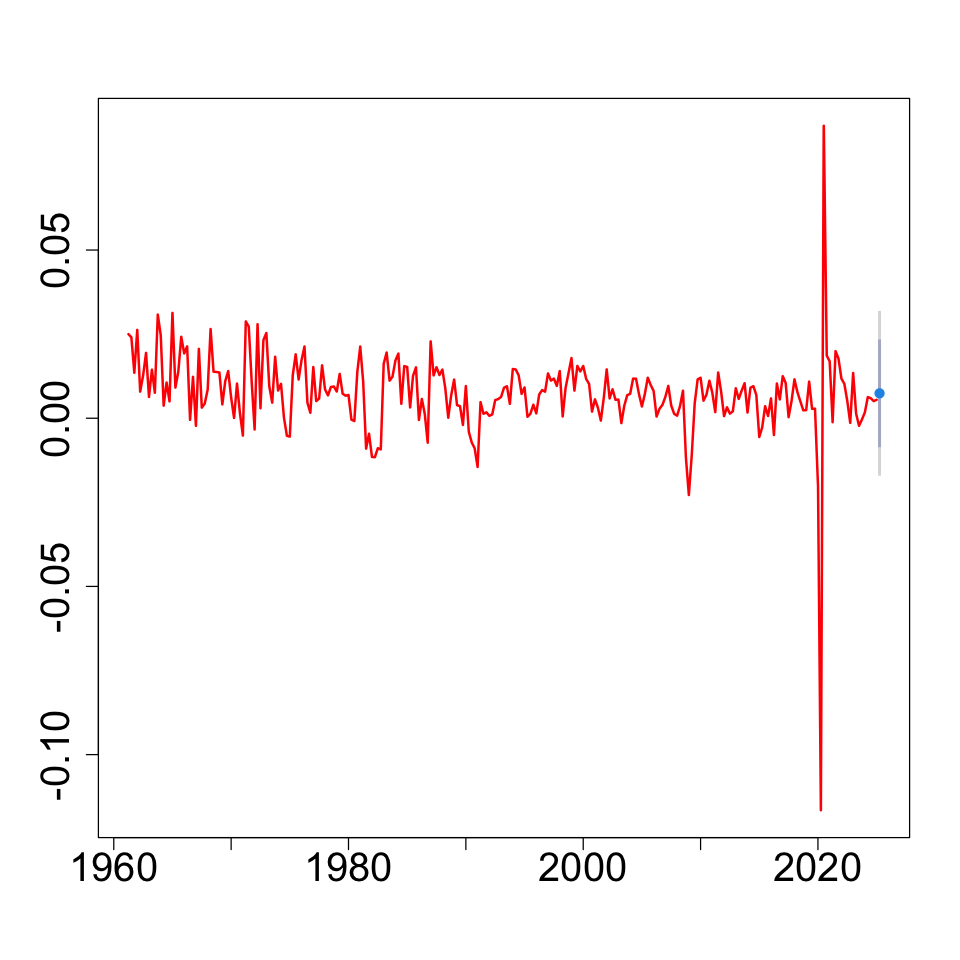

In [17]:
# Set Jupyter/IRkernel figure size in inches for the output cell
options(repr.plot.width = 8, repr.plot.height = 8)

# Enlarge base R graphics text: axis labels, tick labels, and (potential) main title
par(cex.lab = 2, cex.axis = 2, cex.main = 2)

# Plot the 1-step-ahead forecast object from the 'forecast' package.
plot(f.a, aspect.ratio = 1, col = "red", lwd = 2, main = "")

# Forecasting ARIMA models
## ARIMA(1,1) model

**R: Forecasting GDP growth rate using ARIMA(1,1), 1-step ahead**:

$$\color{blue}{y_t = \alpha_0 + \alpha_1 y_{t-1}+\delta_1\epsilon_{t-1} +ϵ_t}$$


In [18]:
library(stargazer)
# Fit an ARIMA(1,1) to already-stationary GDP growth (dgdp)
model.b = arima(dgdp, order = c(1, 0, 1))

# Print the model
stargazer(model.b, type = "text")


                      Dependent variable:    
                  ---------------------------
                             dgdp            
---------------------------------------------
ar1                        0.990***          
                            (0.015)          
                                             
ma1                        -0.964***         
                            (0.024)          
                                             
intercept                  0.008***          
                            (0.002)          
                                             
---------------------------------------------
Observations                  256            
Log Likelihood              760.936          
sigma2                      0.0002           
Akaike Inf. Crit.         -1,513.873         
Note:             *p<0.1; **p<0.05; ***p<0.01


In [19]:
# Load forecasting
library(forecast)

# One-step-ahead forecast from the fitted ARIMA model
# h = 1 → forecast the next period only
# level sets the prediction interval(s); add/remove as you like
f.b = forecast::forecast(model.b, h = 1, level = c(80, 95))

# Print the output
f.b

# Access pieces programmatically
f.b$mean      # point forecast
f.b$lower     # lower bounds for levels specified
f.b$upper     # upper bounds for levels specified

        Point Forecast       Lo 80      Hi 80       Lo 95      Hi 95
2025 Q2    0.005713515 -0.01014489 0.02157192 -0.01853982 0.02996685

,Qtr2
2025,0.005713515


,80%,95%
2025 Q2,-0.01014489,-0.01853982


,80%,95%
2025 Q2,0.02157192,0.02996685


In [20]:
# Manual calcualtions
coef.b = coef(model.b)

alpha0 = coef.b["intercept"] * (1 - coef.b["ar1"])
alpha1 = coef.b["ar1"]
delta1 = coef.b["ma1"]

# Extract last observed value of the stationary series y_T and the correspoding residual e_T
yT = tail(dgdp, n = 1)
eT = tail(residuals(model.b), n = 1)

# Compute the conditional mean for T+1 
yT1.b = alpha0 + alpha1 * yT + delta1 * eT

# Express as ~percent (dgdp is Δlog ⇒ approx growth rate), rounded to two decimal places
yT1.b = round(yT1.b * 100, 2)

# 1-step-ahead point forecast:
cat("ARIMA(1,1) generated 1-step-ahead forcast of the growth rate of the Canadian GDP is", as.numeric(yT1.b), "%.")

ARIMA(1,1) generated 1-step-ahead forcast of the growth rate of the Canadian GDP is 0.57 %.

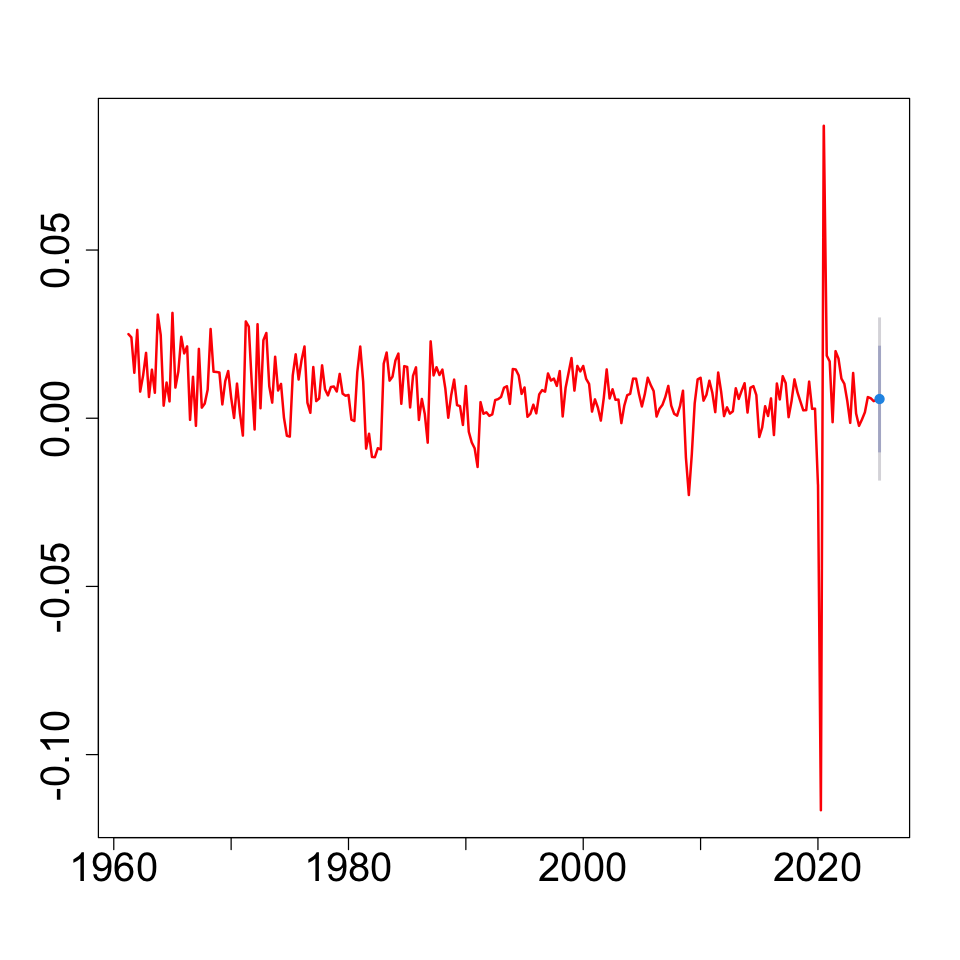

In [21]:
# Set Jupyter/IRkernel figure size in inches for the output cell
options(repr.plot.width = 8, repr.plot.height = 8)

# Enlarge base R graphics text: axis labels, tick labels, and (potential) main title
par(cex.lab = 2, cex.axis = 2, cex.main = 2)

# Plot the 1-step-ahead forecast object from the 'forecast' package.
plot(f.b, aspect.ratio = 1, col = "red", lwd = 2, main = "")

<img src="COLOURBOX36254980.jpg" width="200">

#  Recursive out-of-sample forecasts for ARIMA models

**What this loop is doing (and why)**

We want to evaluate how an AR(1) forecasting model performs **out-of-sample**.  
To do this fairly, we mimic “real time”:

1. **Fix an initial estimation window** of size `Tstar`.  
   - Reason: we need a reasonably long sample to estimate the AR(1) parameters reliably before we start judging forecasts.
2. **Expanding window (a.k.a. recursive estimation):**  
   - At iteration `i`, we estimate the model using `dgdp[1 : (Tstar + i - 1)]`.  
   - This mimics being at time `Tstar + i - 1` in real time, only using data **available then**.
3. **Forecast one step ahead (h = 1):**  
   - Using the model estimated at iteration `i`, we forecast the next observation, which is `dgdp[Tstar + i]`.
4. **Record results:**  
   - We store the point forecast, its 95% interval, the realized value, and the absolute error.  
5. **Repeat** until the end of the sample.  
   - The number of iterations is `Tmax = T - Tstar`.  
   - This produces a sequence of **genuine pseudo-real-time forecasts** for a fair accuracy assessment.

Why not use the full sample each time? Because that would leak future information and overstate forecast performance.  
Why not keep the window rolling with a fixed length? That’s a different design (rolling/slider window). Here we prefer the **expanding** window to use all past info accumulated up to each forecast origin, which often stabilizes AR parameter estimates.


##  Recursive out-of-sample forecasts for AR(1) model

In [22]:
# https://www.rdocumentation.org/packages/forecast/versions/8.16/topics/forecast
library(forecast)

# Length of sample 
T = length(dgdp)

# Container for results
results = data.frame()

# Initial estimation window
Tstar = 200

# Number of iterations
Tmax = T - Tstar

cat("Our data has", T, "observations.\n")
cat("We will keep the first", Tstar, "observations fixed for stability (initial estimation window).\n")
cat("From there, we add one observation at a time and forecast one step ahead at each iteration.\n")
cat("We will produce", Tmax, "out-of-sample 1-step-ahead forecasts, ending at observation", T, ".\n\n")


for (i in 1:Tmax) {
  # Expand window estimation: use data up to time Tstar + i - 1
  model = arima(dgdp[1:(Tstar + i - 1)], order = c(1, 0, 0))
  
  # One-step-ahead forecast with a single 95% PI
  f = forecast::forecast(model, h = 1, level = 95)
  
  # Extract components (coerce to numeric to avoid ts attributes in arithmetic)
  f.mean = as.numeric(f$mean[1])              # point forecast y_{T+1|T}
  f.lower95 = as.numeric(f$lower[1])          # 95% lower bound
  f.upper95 = as.numeric(f$upper[1])          # 95% upper bound
  obs.val = as.numeric(dgdp[Tstar + i])       # actual y_{T+1}
  
  # Absolute forecast error
  f.error = abs(f.mean - obs.val)
  
  # Row to append
  temp = c(f.mean, f.lower95, f.upper95, obs.val, f.error)
  results = rbind(results, temp)
}

# Name the columns
names(results) = c("Mean forecast", "Lower bound 95%", "Upper bound 95%", "Actual value", "Absolute error")

# Quick peek at the first 6 interations
head(results)

# Quick peek at the last 6 iterations
tail(results)

# Save AR(1) rolling results
results.AR1 = results

# Mean Absolute Error (MAE)
mae.AR1 = mean(results.AR1[, "Absolute error"])

# Root Mean Squared Forecast Error (RMSFE)
rmsfe.AR1 = sqrt(mean((results.AR1[, "Mean forecast"] - results.AR1[, "Actual value"])^2))

cat("The MAE is", round(mae.AR1, 5), "and the RMSFE is", round(rmsfe.AR1, 5))

Our data has 256 observations.
We will keep the first 200 observations fixed for stability (initial estimation window).
From there, we add one observation at a time and forecast one step ahead at each iteration.
We will produce 56 out-of-sample 1-step-ahead forecasts, ending at observation 256 .



,Mean forecast,Lower bound 95%,Upper bound 95%,Actual value,Absolute error
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.008011533,-0.007919723,0.02394279,0.0018136394,0.006197894
2,0.005725205,-0.010189328,0.02163974,0.0135896277,0.007864423
3,0.010346690,-0.005565246,0.02625863,0.0079159116,0.002430778
4,0.008136847,-0.007739376,0.02401307,0.0006311038,0.007505743
5,0.005283030,-0.010587519,0.02115358,0.0032454382,0.002037592
6,0.006279366,-0.009554827,0.02211356,0.0013675060,0.004911860


,Mean forecast,Lower bound 95%,Upper bound 95%,Actual value,Absolute error
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
51,0.007309076,-0.01745116,0.03206931,-0.0003829651,0.007692042
52,0.007308181,-0.01742088,0.03203724,0.0017659246,0.005542256
53,0.007335084,-0.01735429,0.03202446,0.0062945465,0.001040538
54,0.007451791,-0.01718907,0.03209266,0.0059438355,0.001507956
55,0.007436371,-0.01715664,0.03202938,0.0050857420,0.002350629
56,0.007403866,-0.01714256,0.03195029,0.0054794362,0.001924430


The MAE is 0.00988 and the RMSFE is 0.02609

##  Recursive out-of-sample forecasts for ARIMA(1,1) model

**Note that the only difference between the two recursive loops (AR(1) and ARIMA(1,1)) is the order argument of the arima function.**

In [23]:
# https://www.rdocumentation.org/packages/forecast/versions/8.16/topics/forecast
library(forecast)

# Length of sample 
T = length(dgdp)

# Container for results
results = data.frame()

# Initial estimation window
Tstar = 200

# Number of iterations
Tmax = T - Tstar

cat("Our data has", T, "observations.\n")
cat("We will keep the first", Tstar, "observations fixed for stability (initial estimation window).\n")
cat("From there, we add one observation at a time and forecast one step ahead at each iteration.\n")
cat("We will produce", Tmax, "out-of-sample 1-step-ahead forecasts, ending at observation", T, ".\n\n")


for (i in 1:Tmax) {
  # Expand window estimation: use data up to time Tstar + i - 1
  model = arima(dgdp[1:(Tstar + i - 1)], order = c(1, 0, 1))
  
  # One-step-ahead forecast with a single 95% PI
  f = forecast::forecast(model, h = 1, level = 95)
  
  # Extract components (coerce to numeric to avoid ts attributes in arithmetic)
  f.mean = as.numeric(f$mean[1])              # point forecast y_{T+1|T}
  f.lower95 = as.numeric(f$lower[1])          # 95% lower bound
  f.upper95 = as.numeric(f$upper[1])          # 95% upper bound
  obs.val = as.numeric(dgdp[Tstar + i])       # actual y_{T+1}
  
  # Absolute forecast error
  f.error = abs(f.mean - obs.val)
  
  # Row to append
  temp = c(f.mean, f.lower95, f.upper95, obs.val, f.error)
  results = rbind(results, temp)
}

# Name the columns
names(results) = c("Mean forecast", "Lower bound 95%", "Upper bound 95%", "Actual value", "Absolute error")

# Quick peek at the first 6 interations
head(results)

# Quick peek at the last 6 iterations
tail(results)

# Save ARMA(1,1) rolling results
results.ARMA11 = results

# Mean Absolute Error (MAE)
mae.ARMA11 = mean(results.ARMA11[, "Absolute error"])

# Root Mean Squared Forecast Error (RMSFE)
rmsfe.ARMA11 = sqrt(mean((results.ARMA11[, "Mean forecast"] - results.ARMA11[, "Actual value"])^2))

cat("The MAE is", round(mae.ARMA11, 5), "and the RMSFE is", round(rmsfe.ARMA11, 5))

Our data has 256 observations.
We will keep the first 200 observations fixed for stability (initial estimation window).
From there, we add one observation at a time and forecast one step ahead at each iteration.
We will produce 56 out-of-sample 1-step-ahead forecasts, ending at observation 256 .



,Mean forecast,Lower bound 95%,Upper bound 95%,Actual value,Absolute error
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.008304613,-0.007545557,0.02415478,0.0018136394,0.006490974
2,0.006067570,-0.009768451,0.02190359,0.0135896277,0.007522058
3,0.009450258,-0.006380321,0.02528084,0.0079159116,0.001534347
4,0.008524317,-0.007268620,0.02431725,0.0006311038,0.007893213
5,0.005759379,-0.010031834,0.02155059,0.0032454382,0.002513941
6,0.005805135,-0.009951210,0.02156148,0.0013675060,0.004437629


,Mean forecast,Lower bound 95%,Upper bound 95%,Actual value,Absolute error
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
51,0.005959374,-0.01856922,0.03048797,-0.0003829651,0.0063423392
52,0.005751857,-0.01873845,0.03024216,0.0017659246,0.0039859325
53,0.005631166,-0.01881470,0.03007703,0.0062945465,0.0006633803
54,0.005654665,-0.01874172,0.03005105,0.0059438355,0.0002891704
55,0.005684919,-0.01866375,0.03003358,0.0050857420,0.0005991766
56,0.005694134,-0.01860657,0.02999483,0.0054794362,0.0002146973


The MAE is 0.00984 and the RMSFE is 0.02605

**Conclusion:** Both AR(1) and ARIMA(1,1) models perform virtually identical when comes to forecasting growth rate of the Canadian GDP one period ahead.

<img src="COLOURBOX36254980.jpg" width="200">

# Forecasting ADL models
## ADL(0,1) model

**Note: We will forecast ADL(0,1) and ADL(1,1) models *for illustration*, so we can match R’s built-in functions with our manual computations. As we saw last week, the best model by BIC was ADL(0,1), while the best model by AIC was a subset ADL with the first and third lag of the change in weekly hours worked.**

**R: Forecasting GDP growth rate using lagged value of the change in hours worked, 1-step ahead**:
$$\color{blue}{y_t = \alpha_0 + \beta_1x_{t-1} +ϵ_t}$$

In [24]:
# Align series on overlapping dates (common time index)
data = ts.intersect(dgdp, dhours)

# ADL(0,1): dgdp_t on lagged dhours_{t-1}
library(dynlm)
model.c = dynlm(dgdp ~ L(dhours, 1), data)

# Print a compact regression table
library(stargazer)
stargazer(model.c, type = "text")


                        Dependent variable:    
                    ---------------------------
                               dgdp            
-----------------------------------------------
L(dhours, 1)                  0.005**          
                              (0.002)          
                                               
Constant                     0.008***          
                              (0.001)          
                                               
-----------------------------------------------
Observations                    249            
R2                             0.022           
Adjusted R2                    0.018           
Residual Std. Error      0.013 (df = 247)      
F Statistic            5.617** (df = 1; 247)   
Note:               *p<0.1; **p<0.05; ***p<0.01


In [25]:
# 1-step ahead forecast
newdata = data.frame("dhours" = tail(data[,"dhours"], n=1))
# 95% prediction interval (future outcome uncertainty)
f.c = predict(model.c, newdata = newdata, interval = "prediction", level = 0.95)
f.c

,fit,lwr,upr
1,0.008041573,-0.01667723,0.03276038


In [26]:
# --- Manual calculations for 1-step-ahead ADL(0,1) forecast from model.c ---
# https://www.econometrics-with-r.org/14.5-apatadlm.html
coef.c = coef(model.c)

alpha0 = coef.c["(Intercept)"]
beta1  = coef.c["L(dhours, 1)"]

#Use the most recent dhours (time T) to predict dgdp at T+1
T = nrow(data)
yT1.c = alpha0 + beta1 * data[T, "dhours"]

# Express as ~percent (dgdp is Δlog ⇒ approx growth rate), rounded to two decimal places
yT1.c = round(yT1.c * 100, 7)

# 1-step-ahead point forecast:
cat("ADL(0,1) generated 1-step-ahead forcast of the growth rate of the Canadian GDP is", as.numeric(yT1.c),"%.")

ADL(0,1) generated 1-step-ahead forcast of the growth rate of the Canadian GDP is 0.8041573 %.

# Forecasting ADL models
## ADL(1,1) model

**R: Forecasting GDP growth rate using ADL(1,1) model, 1-step ahead**:
$$\color{blue}{y_t = \alpha_0 + \alpha_1y_{t-1}+ \beta_1x_{t-1} +ϵ_t}$$

In [27]:
# Align series on overlapping dates (common time index)
data = ts.intersect(dgdp, dhours)

# ADL(1,1): dgdp_t on lagged dgdp_{t-1} and lagged dhours_{t-1} 
library(dynlm)
model.d = dynlm(dgdp ~ L(dgdp, 1) + L(dhours, 1), data)

# Print a compact regression table
library(stargazer)
stargazer(model.d, type = "text")


                        Dependent variable:    
                    ---------------------------
                               dgdp            
-----------------------------------------------
L(dgdp, 1)                    -0.016           
                              (0.065)          
                                               
L(dhours, 1)                  0.005**          
                              (0.002)          
                                               
Constant                     0.008***          
                              (0.001)          
                                               
-----------------------------------------------
Observations                    249            
R2                             0.022           
Adjusted R2                    0.015           
Residual Std. Error      0.013 (df = 246)      
F Statistic            2.828* (df = 2; 246)    
Note:               *p<0.1; **p<0.05; ***p<0.01


In [28]:
# 1-step ahead forecast
newdata = data.frame("dgdp" = tail(data[,"dgdp"], n=1), "dhours" = tail(data[,"dhours"], n=1))
# 95% prediction interval (future outcome uncertainty)
f.d = predict(model.d, newdata = newdata, interval = "prediction", level = 0.95)
f.d

,fit,lwr,upr
1,0.008216719,-0.01658865,0.03302209


In [29]:
# --- Manual calculations for 1-step-ahead ADL(0,1) forecast from model.c ---
# https://www.econometrics-with-r.org/14.5-apatadlm.html
coef.d = coef(model.d)

alpha0 = coef.d["(Intercept)"]
beta1  = coef.d["L(dhours, 1)"]
alpha1  = coef.d["L(dgdp, 1)"]

#Use the most recent dgdp and the most recent dhours (time T) to predict dgdp at T+1
T = nrow(data)
yT1.d = alpha0 + alpha1 * data[T, "dgdp"] + beta1 * data[T, "dhours"]

# Express as ~percent (dgdp is Δlog ⇒ approx growth rate), rounded to two decimal places
yT1.d = round(yT1.d * 100, 7)

# 1-step-ahead point forecast:
cat("ADL(1,1) generated 1-step-ahead forcast of the growth rate of the Canadian GDP is", as.numeric(yT1.d),"%.")

ADL(1,1) generated 1-step-ahead forcast of the growth rate of the Canadian GDP is 0.8216719 %.

<img src="COLOURBOX36254980.jpg" width="200">

# Recursive out-of-sample forecasts for an ADL(0,1) model

In [30]:
# Align series on overlapping dates (common time index)
data = ts.intersect(dgdp, dhours)

# Length of sample 
T = nrow(data)

# Container for results
results = data.frame()

# Initial estimation window
Tstar = 200

# Number of iterations
Tmax = T - Tstar

for (i in 1: (T - Tstar)) {
    model = dynlm(dgdp ~  L(dhours, 1), data[1: (Tstar + i - 1), ])
    newdata = data.frame("dhours" = data[(Tstar + i - 1), "dhours"])

    # One-step-ahead forecast with a single 95% PI
    f = predict(model, newdata = newdata, interval = "prediction", level = 0.95)

    # Extract components (coerce to numeric to avoid ts attributes in arithmetic)
    f.mean = as.numeric(f[1,1])
    f.lower95 = as.numeric(f[1,2])
    f.upper95 = as.numeric(f[1,3])
    
    # Realized value at time (Tstar + i) to compare against the forecast
    obs.val = as.numeric(data[(Tstar + i), "dgdp"])
    
    # Absolute forecast error
    f.error = abs(f.mean - obs.val)
    
    # Row to append
    temp = c(f.mean, f.lower95, f.upper95, obs.val, f.error)
    results = rbind(results, temp)
}
names(results)=c("Mean forecast", "Lower bound 95%", "Upper bound 95%", "Actual value", "Absolute error")

# Quick peek at the first 6 iterations
head(results)

# Quick peek at the last 6 iterations
tail(results)

# Save ADL(0,1) rolling results
results.ADL01 = results

# Mean Absolute Error (MAE)
mae.ADL01 = mean(results.ADL01[, "Absolute error"])

# Root Mean Squared Forecast Error (RMSFE)
rmsfe.ADL01 = sqrt(mean((results.ADL01[, "Mean forecast"] - results.ADL01[, "Actual value"])^2))

cat("The MAE is", round(mae.ADL01, 5), "and the RMSFE is", round(rmsfe.ADL01, 5))

,Mean forecast,Lower bound 95%,Upper bound 95%,Actual value,Absolute error
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.011759182,-0.01319617,0.03671454,0.0018136394,0.009945543
2,0.002835183,-0.02217004,0.02784041,0.0135896277,0.010754445
3,0.009134477,-0.01561688,0.03388583,0.0079159116,0.001218565
4,0.010184359,-0.01462690,0.03499561,0.0006311038,0.009553255
5,0.008609535,-0.01612281,0.03334188,0.0032454382,0.005364097
6,0.005984830,-0.01876233,0.03073199,0.0013675060,0.004617324


,Mean forecast,Lower bound 95%,Upper bound 95%,Actual value,Absolute error
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
45,0.008609535,-0.01612281,0.03334188,0.010229149,0.001619613
46,0.007034712,-0.01768454,0.03175396,0.005138201,0.001896511
47,0.008609535,-0.01612281,0.03334188,-0.001370987,0.009980522
48,0.007034712,-0.01768454,0.03175396,0.013454326,0.006419614
49,0.009659418,-0.01511825,0.03443709,0.001425423,0.008233995
50,0.008609535,-0.01612281,0.03334188,-0.002258095,0.010867631


The MAE is 0.00962 and the RMSFE is 0.02192

# Recursive out-of-sample forecasts for an ADL(1,1) model

In [31]:
# Align series on overlapping dates (common time index)
data = ts.intersect(dgdp, dhours)

# Length of sample 
T = nrow(data)

# Container for results
results = data.frame()

# Initial estimation window
Tstar = 200

# Number of iterations
Tmax = T - Tstar

for (i in 1: (T - Tstar)) {
    model = dynlm(dgdp ~  L(dgdp, 1) + L(dhours, 1), data[1: (Tstar + i - 1), ])
    newdata = data.frame("dgdp" = data[(Tstar + i - 1), "dgdp"],
                         "dhours" = data[(Tstar + i - 1), "dhours"])

    # One-step-ahead forecast with a single 95% PI
    f = predict(model, newdata = newdata, interval = "prediction", level = 0.95)
    
    # Extract components (coerce to numeric to avoid ts attributes in arithmetic)
    f.mean = as.numeric(f[1,1])
    f.lower95 = as.numeric(f[1,2])
    f.upper95 = as.numeric(f[1,3])
    
    # Realized value at time (Tstar + i) to compare against the forecast
    obs.val = as.numeric(data[(Tstar + i), "dgdp"])
    
    # Absolute forecast error
    f.error = abs(f.mean - obs.val)
    
    # Row to append
    temp = c(f.mean, f.lower95, f.upper95, obs.val, f.error)
    results = rbind(results, temp)
}
names(results)=c("Mean forecast", "Lower bound 95%", "Upper bound 95%", "Actual value", "Absolute error")

# Quick peek at the first 6 iterations
head(results)

# Quick peek at the last 6 iterations
tail(results)

# Save ADL(1,1) rolling results
results.ADL11 = results

# Mean Absolute Error (MAE)
mae.ADL11 = mean(results.ADL11[, "Absolute error"])

# Root Mean Squared Forecast Error (RMSFE)
rmsfe.ADL11 = sqrt(mean((results.ADL11[, "Mean forecast"] - results.ADL11[, "Actual value"])^2))

cat("The MAE is", round(mae.ADL11, 5), "and the RMSFE is", round(rmsfe.ADL11, 5))

,Mean forecast,Lower bound 95%,Upper bound 95%,Actual value,Absolute error
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.011674797,-0.01331729,0.03666688,0.0018136394,0.009861158
2,0.002872213,-0.02215299,0.02789742,0.0135896277,0.010717414
3,0.008980548,-0.01579286,0.03375396,0.0079159116,0.001064637
4,0.010102980,-0.01473300,0.03493896,0.0006311038,0.009471876
5,0.008635228,-0.01614105,0.03341151,0.0032454382,0.005389789
6,0.005987289,-0.01877879,0.03075337,0.0013675060,0.004619783


,Mean forecast,Lower bound 95%,Upper bound 95%,Actual value,Absolute error
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
45,0.008482817,-0.01626973,0.03323536,0.010229149,0.001746331
46,0.006936716,-0.01780460,0.03167803,0.005138201,0.001798516
47,0.008573624,-0.01618317,0.03333042,-0.001370987,0.009944610
48,0.007095270,-0.01766379,0.03185433,0.013454326,0.006359057
49,0.009504839,-0.01529319,0.03430287,0.001425423,0.008079416
50,0.008624371,-0.01614750,0.03339624,-0.002258095,0.010882466


The MAE is 0.00961 and the RMSFE is 0.02184

# Comparison across the models:
## AR(1), ARMA(1,1), ADL(0,1), ADL(1,1)

In [32]:
data.frame("AR(1)" = mae.AR1, "ARMA(1,1)"  = mae.ARMA11, "ADL(0,1)" = mae.ADL01, "ADL(1,1)"  = mae.ADL11)
data.frame("AR(1)" = rmsfe.AR1, "ARMA(1,1)"  = rmsfe.ARMA11, "ADL(0,1)" = rmsfe.ADL01, "ADL(1,1)"  = rmsfe.ADL11)


AR.1.,ARMA.1.1.,ADL.0.1.,ADL.1.1.
<dbl>,<dbl>,<dbl>,<dbl>
0.009880319,0.009839268,0.009619095,0.00961235


AR.1.,ARMA.1.1.,ADL.0.1.,ADL.1.1.
<dbl>,<dbl>,<dbl>,<dbl>
0.02608751,0.02605189,0.02192396,0.02184136


Our tables shows the lowest MAE and RMSFE for ADL(1,1), slightly better than ADL(0,1) and clearly better than AR(1)/ARMA(1,1). That means ADL(1,1) is your best of the four on this sample.